<a href="https://colab.research.google.com/github/rdukewiesenb/Project2-MicrobiomePredictions/blob/master/MicrobiomePredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [1]:
# Importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
%%capture
import sys
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install plotly==4.*
    !pip install pdpbox

In [3]:
%%capture
pip install fbprophet

In [4]:
# What version of prophet are we using?
import fbprophet
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


In [5]:
url = 'https://data.edmonton.ca/api/views/s4ws-tdws/rows.csv?accessType=DOWNLOAD'

df = pd.read_csv(url,
                 parse_dates=['Date'],
                 index_col='Row ID')

## EDA

In [6]:
# Let's get down some basics

# Shape
df.shape

(62155, 28)

In [7]:
# What is my research question?
  # What will be the temperature in December 2020?

# Because I am predicting the weather for 
# a specific month, I will draw a new dataset
# from the main one.

# december = df[df['Month'] == 12]

In [8]:
# Now, let's take a deeper look.
%%capture

!pip install pandas-profiling==2.*

In [9]:
# What are some problems we might encounter?
  # Constants
  # NaNs
  # Zeros
  # High Cardinality

In [10]:
# What is the timespan of the dataset?
print('Earliest Year: ', df['Year'].min())
print('Latest Year: ', df['Year'].max())

Earliest Year:  2000
Latest Year:  2020


In [11]:
# Are there any NaNs?
# If there are, let's deal with them.
df.isnull().sum()

Station ID                                      0
Station Name                                    0
Station Province                                0
Station Latitude                                0
Station Longitude                               0
Location                                        0
Station Elevation (m)                           0
Station Climate Identifier                      0
Station WMO Identifier                        654
Station TC Identifier                           0
Year                                            0
Month                                           0
Day                                             0
Data Quality                                29014
Date                                            0
Maximum Temperature (C)                      3304
Minimum Temperature (C)                      2786
Mean Temperature (C)                         3528
Heating Degree Days (C)                      3528
Cooling Degree Days (C)                      3528


In [12]:
df.fillna('NaN')

,Station ID,Station Name,Station Province,Station Latitude,Station Longitude,Location,Station Elevation (m),Station Climate Identifier,Station WMO Identifier,Station TC Identifier,Year,Month,Day,Data Quality,Date,Maximum Temperature (C),Minimum Temperature (C),Mean Temperature (C),Heating Degree Days (C),Cooling Degree Days (C),Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precipitation (mm),Snow on Ground (cm),Speed of Maximum Wind Gust (km/h),Direction of Maximum Wind Gust (10s Deg)
Row ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4685020170223,46850,THORSBY AGCM,ALBERTA,53.22,-113.89,"(53.22, -113.89)",754.0,3016441,71504,PTH,2017,2,23,†,2017-02-23,-0.9,-8.3,-4.6,22.6,0,NaN,M,NaN,M,0,NaN,NaN,NaN
4685020170306,46850,THORSBY AGCM,ALBERTA,53.22,-113.89,"(53.22, -113.89)",754.0,3016441,71504,PTH,2017,3,6,†,2017-03-06,-10.9,-21.7,-16.3,34.3,0,NaN,M,NaN,M,3,NaN,NaN,NaN
4685020170221,46850,THORSBY AGCM,ALBERTA,53.22,-113.89,"(53.22, -113.89)",754.0,3016441,71504,PTH,2017,2,21,†,2017-02-21,3.7,-2.8,0.5,17.5,0,NaN,M,NaN,M,0,NaN,NaN,NaN
4685020170215,46850,THORSBY AGCM,ALBERTA,53.22,-113.89,"(53.22, -113.89)",754.0,3016441,71504,PTH,2017,2,15,†,2017-02-15,15.2,0,7.6,10.4,0,NaN,M,NaN,M,0,NaN,NaN,NaN
4685020170126,46850,THORSBY AGCM,ALBERTA,53.22,-113.89,"(53.22, -113.89)",754.0,3016441,71504,PTH,2017,1,26,†,2017-01-26,3,-5.9,-1.5,19.5,0,NaN,M,NaN,M,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5175820200923,51758,EDMONTON VILLENEUVE A,ALBERTA,53.67,-113.86,"(53.67, -113.86)",687.6,3012229,71664,ZVL,2020,9,23,NaN,2020-09-23,20.7,6.1,13.4,4.6,0,NaN,NaN,NaN,NaN,0,NaN,41,15
2749220200923,27492,EDMONTON STONY PLAIN CS,ALBERTA,53.55,-114.11,"(53.55, -114.11)",766.3,301A001,71127,XPS,2020,9,23,NaN,2020-09-23,19.8,5.1,12.4,5.6,0,NaN,NaN,NaN,NaN,0,NaN,34,15
4685020200922,46850,THORSBY AGCM,ALBERTA,53.22,-113.89,"(53.22, -113.89)",754.0,3016441,71504,PTH,2020,9,22,NaN,2020-09-22,18.2,6.4,12.3,5.7,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


In [13]:
# Here are all of our station
station_id = df[['Station Name', 'Station ID']]
station_id.head()

,Station Name,Station ID
Row ID,,
4685020170223,THORSBY AGCM,46850
4685020170306,THORSBY AGCM,46850
4685020170221,THORSBY AGCM,46850
4685020170215,THORSBY AGCM,46850
4685020170126,THORSBY AGCM,46850


In [14]:
df.columns

Index(['Station ID', 'Station Name', 'Station Province', 'Station Latitude',
       'Station Longitude', 'Location', 'Station Elevation (m)',
       'Station Climate Identifier', 'Station WMO Identifier',
       'Station TC Identifier', 'Year', 'Month', 'Day', 'Data Quality', 'Date',
       'Maximum Temperature (C)', 'Minimum Temperature (C)',
       'Mean Temperature (C)', 'Heating Degree Days (C)',
       'Cooling Degree Days (C)', 'Total Rain (mm)', 'Total Rain Flag',
       'Total Snow (cm)', 'Total Snow Flag', 'Total Precipitation (mm)',
       'Snow on Ground (cm)', 'Speed of Maximum Wind Gust (km/h)',
       'Direction of Maximum Wind Gust (10s Deg)'],
      dtype='object')

In [15]:
# Make sure data is tidy!

In [16]:
# Our target is "___"-skewed
df['Station ID'].value_counts()

1870     7571
27793    7569
27492    7567
27214    7567
30907    7475
41783    6443
46911    4961
46850    4954
47088    4641
51758    2753
53718     654
Name: Station ID, dtype: int64

In [17]:
# Pre-wrangling reflection

# What features will I need in order to answer 
# my research question?
  #
# Will I need to engineer any new features? If so, what are they?
  #
# What will my target be?
  #

# Will I be building a classification or regression model?
  # Regression; my target is continuous.

# Wrangle Data

In [18]:
# Column transformer

In [19]:
def wrangle(df):
  df = df.copy()

  # Engineering a new feature
  df['Snow on Ground'] = ((df['Mean Temperature (C)'] <= 0).astype(int) & 
                    (df['Total Precipitation (mm)'] > 0)).astype(int)

  # Dropping high-cardinality features
  # unique_cats = df.select_dtypes('object').nunique()
  # high_card_cols = [col for col in unique_cats.index if unique_cats[col] > 10]
  # df = df.drop(high_card_cols, axis=1)
  df['Station Name'] = df['Station Name'].astype('category')

  # Columns to keep
  keep_cols = ['Station Name', 'Mean Temperature (C)', 'Year', 'Month', 'Day',
               'Maximum Temperature (C)', 'Minimum Temperature (C)',
               'Heating Degree Days (C)', 
               'Cooling Degree Days (C)',
               'Total Rain (mm)', 'Total Snow (cm)', 'Total Precipitation (mm)',
               'Snow on Ground']

  df = df[keep_cols]
#   df.dropna(axis=1, thresh=100)
  def replace(i):
    i.fillna(0, inplace=True)
    return i
  df[['Total Rain (mm)', 'Total Snow (cm)', 
      'Total Precipitation (mm)']] = replace(df[['Total Rain (mm)', 
                                                 'Total Snow (cm)', 
                                                 'Total Precipitation (mm)']])
  df = df.dropna()                                           

#   df['is_great'] = (df['overall'] >= 4).astype(int)
#   df.drop('overall', axis=1)

  return df

In [20]:
df = wrangle(df)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Split Data

In [21]:
# NOTE: train-test split along dates
# Train: 2000-2017
  # Val: 2018
  # Test: 2019

# ... to test DECEMBER 2020!

target = 'Station Name'
y = df[target]
X = df.drop(target, axis=1)

from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

# Cross validation
X_train, X_val, y_train, y_val = tts(X_train, y_train, test_size=0.2, random_state=42)



# train = december.loc[december['Year'] <= 2017]
# print('Train Min: ', train['Year'].min())
# print('Train Max: ', train['Year'].max())

# val = december.loc[december['Year'] == 2018]
# print('Val Min: ', val['Year'].min())
# print('Val Max:', val['Year'].max())

# test = december.loc[december['Year'] == 2019]
# print('Test Min: ', test['Year'].min())
# print('Test Max:', test['Year'].max())

In [22]:
# Based on the profile report, here are the issues
# we need to take care of:
  # Constants
  # NaNs
  # Zeros
  # High Cardinality

In [23]:
# simp = simpimp(missing_values=np.nan, strategy='mean')
# simp.fit(train)

# Establish Baseline

In [24]:
# What kind of baseline will we have? MAE, R^2, etc?
  # 
# Why?

In [25]:
# Accuracy Score
print('Accuracy Score Baseline: ', y_train.value_counts(normalize=True).max())

Accuracy Score Baseline:  0.12974413646055438


In [26]:
# TopN Accuracy
# Is the actual value any of the top 3 predictions?
# If so, than my prediction is true.

## **IMPORTANT NOTE: Models 1 and 2 will answer a research question that will fulfill the rubric. Model 3 will answers the main research question that will be answered in the blog post.**

(Main Research Question:  What will be the temperature in December 2020?)

# **Model 1: Linear Model**

Research question: Predicting the whether it snowed in Decembers.

## Build Model 1

In [27]:
# Because our target is continuous,
# we will use one-hot encoding.
# (We already imported LinearRegression for the R^2 Score.)

from category_encoders import OneHotEncoder as ohe
from category_encoders import OrdinalEncoder as oe

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer as simpimp
from sklearn.preprocessing import StandardScaler as stanscale
from sklearn.linear_model import LinearRegression as linreg
from sklearn.linear_model import LogisticRegression as logreg

model1 = make_pipeline(
    oe(),
    simpimp(),
    stanscale(),
    logreg(n_jobs=-1)
)

model1.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=-1, penalty='l2',
                                    random_state=None,

## Tune Model 1

> ### Feature Importance 

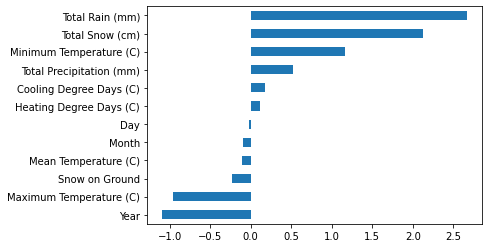

In [28]:
pd.Series(model1.named_steps['logisticregression'].coef_[0], index=X_train.columns).sort_values().plot(kind='barh');

## Check Metrics, Model 1

> ### Accuracy Score



In [29]:
print('Linear Regression Training Accuracy: ', model1.score(X_train, y_train))
print('Linear Regression Validation Accuracy: ', model1.score(X_val, y_val))

Linear Regression Training Accuracy:  0.20301172707889126
Linear Regression Validation Accuracy:  0.20200405074085917


### Confusion Matrix

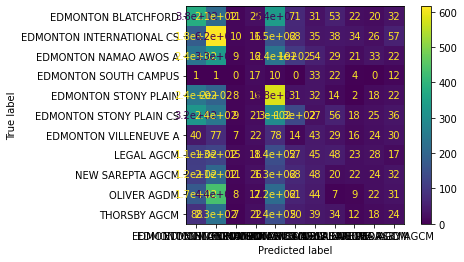

In [30]:
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve
import matplotlib.pyplot as plt

plot_confusion_matrix(model1, X_val, y_val);

## Build a PDP plot

> ### Line Plot 


(<Figure size 1080x3240 with 12 Axes>,
 {'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7f9e5c3c6128>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f9e5c4773c8>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


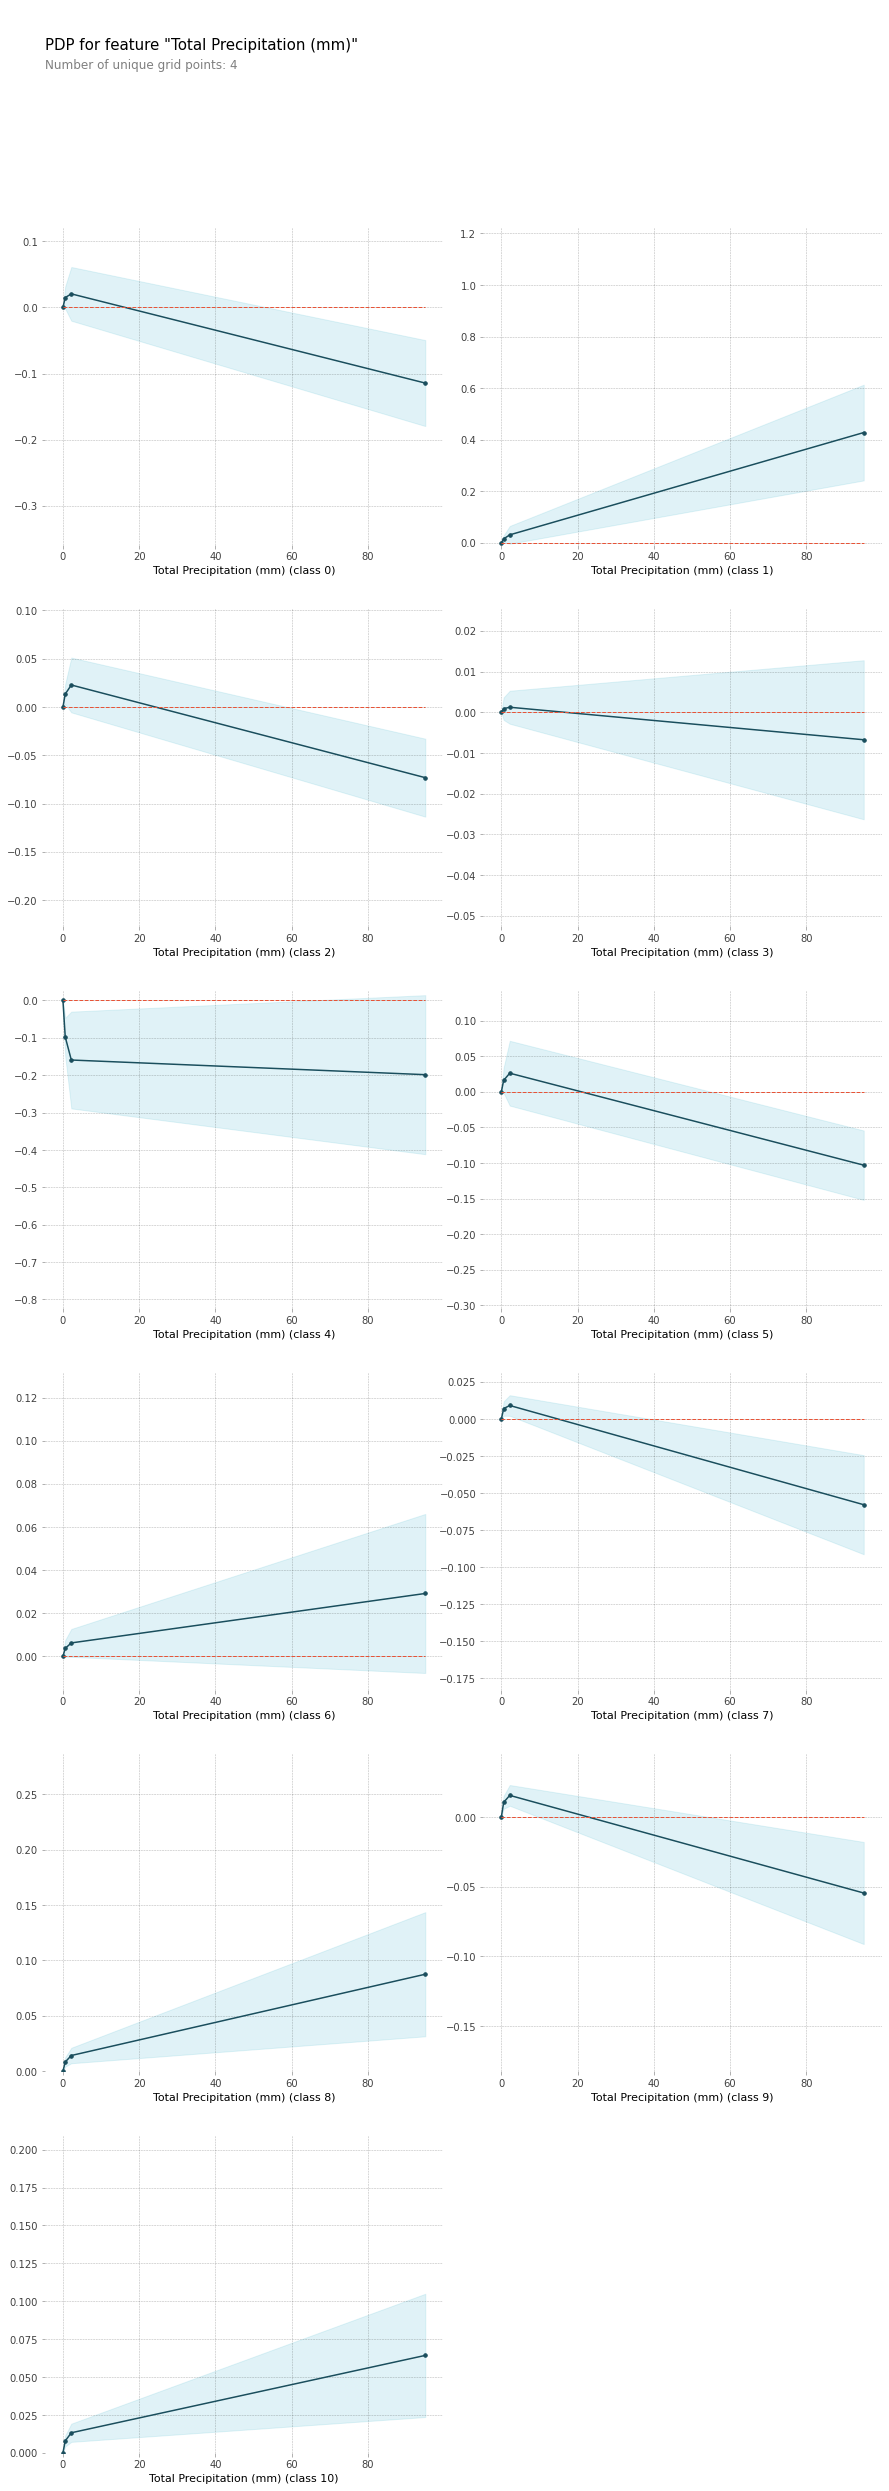

In [31]:
# Isolated
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

feature = 'Total Precipitation (mm)'
isolate = pdp_isolate(
    model=model1,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolate, feature)
# rename y axis ticks

> ### Grid/Contour Plot 

(<Figure size 1080x3384 with 23 Axes>,
 {'pdp_inter_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7f9e5c1d0518>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f9e5c402828>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


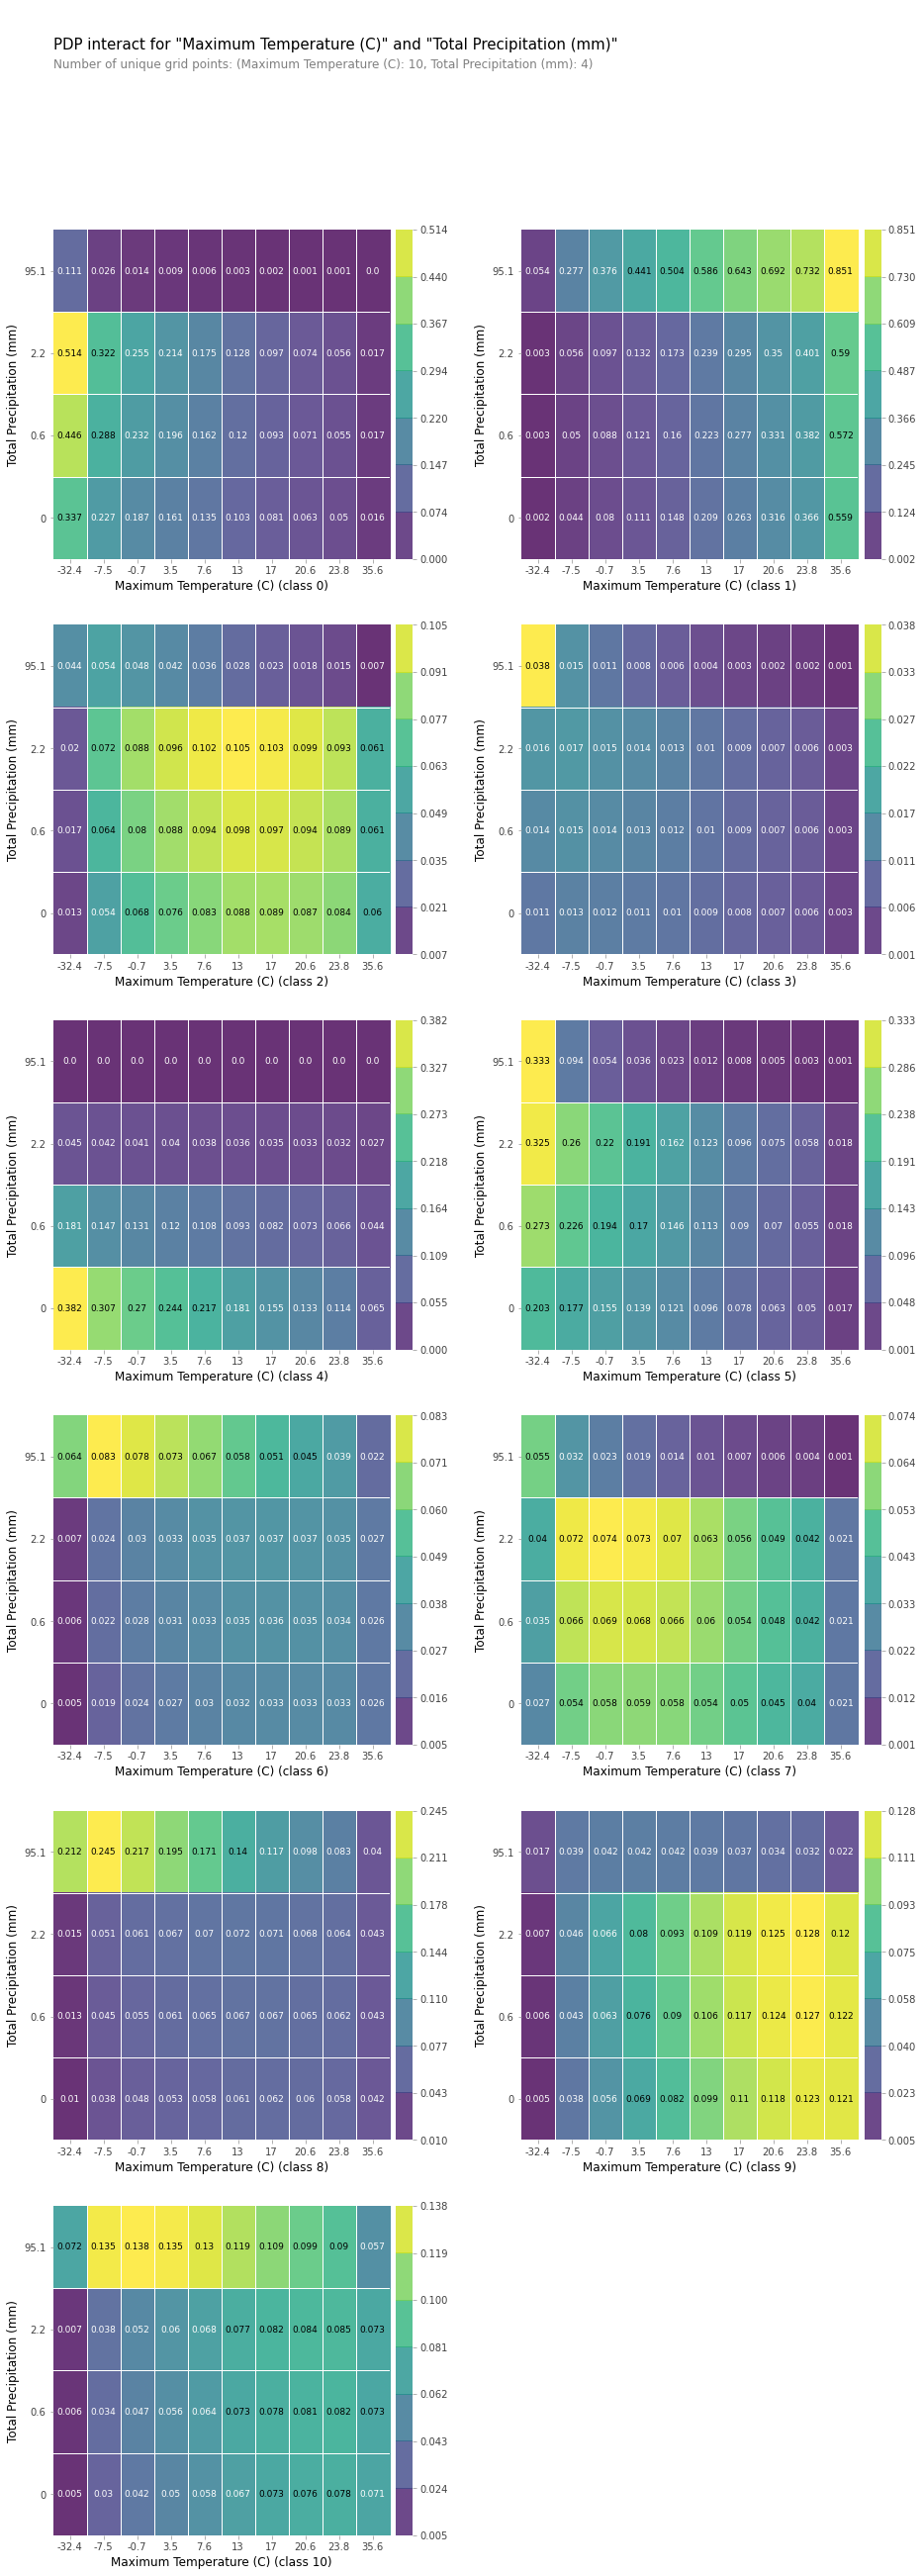

In [32]:
features = ['Maximum Temperature (C)', 'Total Precipitation (mm)']
interact = pdp_interact(
    model=model1,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interact, features, plot_type='grid')

---

#######################################################################################################

---

# **Build Model 2: Tree-based Model**

## Build Model 2

In [33]:
# use xgboost
from xgboost import XGBClassifier as xgbc

model2 = make_pipeline(
    oe(),
    simpimp(),
    xgbc(n_jobs=-1)
)

model2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                               objective='multi:so

## Tune Model 2

> ### Feature Importance 

In [34]:
feat_imp = model2.named_steps['xgbclassifier'].feature_importances_
feat_imp

array([0.01471353, 0.28752074, 0.04811916, 0.01237143, 0.05002653,
       0.0513197 , 0.        , 0.        , 0.16734868, 0.15271534,
       0.14395772, 0.07190714], dtype=float32)

In [35]:
features = X_train.columns
features

Index(['Mean Temperature (C)', 'Year', 'Month', 'Day',
       'Maximum Temperature (C)', 'Minimum Temperature (C)',
       'Heating Degree Days (C)', 'Cooling Degree Days (C)', 'Total Rain (mm)',
       'Total Snow (cm)', 'Total Precipitation (mm)', 'Snow on Ground'],
      dtype='object')

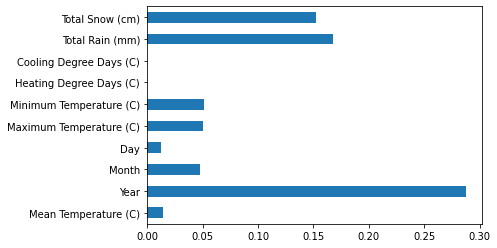

In [36]:
pd.Series(feat_imp, features).head(10).plot(kind='barh')

## Check Metrics, Model 2

> ### Accuracy Score 

In [37]:
print('XGBoost Training Accuracy: ', model2.score(X_train, y_train))
print('XGBoost Regression Validation Accuracy: ', model2.score(X_val, y_val))

XGBoost Training Accuracy:  0.27579957356076756
XGBoost Regression Validation Accuracy:  0.2576484383328003


## Build a PDP plot

> ### Line Plot 

In [38]:
!pip install matplotlib==2.0.1

     |████████████████████████████████| 14.6MB 314kB/s 
ERROR: seaborn 0.10.1 has requirement matplotlib>=2.1.2, but you'll have matplotlib 2.0.1 which is incompatible.
ERROR: pycocotools 2.0.2 has requirement matplotlib>=2.1.0, but you'll have matplotlib 2.0.1 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.0.1 which is incompatible.
ERROR: phik 0.10.0 has requirement matplotlib>=2.2.3, but you'll have matplotlib 2.0.1 which is incompatible.
ERROR: pdpbox 0.2.0 has requirement matplotlib>=2.1.2, but you'll have matplotlib 2.0.1 which is incompatible.
ERROR: pandas-profiling 2.9.0 has requirement matplotlib>=3.2.0, but you'll have matplotlib 2.0.1 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.0.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation:

In [39]:
X.columns

Index(['Mean Temperature (C)', 'Year', 'Month', 'Day',
       'Maximum Temperature (C)', 'Minimum Temperature (C)',
       'Heating Degree Days (C)', 'Cooling Degree Days (C)', 'Total Rain (mm)',
       'Total Snow (cm)', 'Total Precipitation (mm)', 'Snow on Ground'],
      dtype='object')

In [40]:
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

(<Figure size 1080x3240 with 12 Axes>,
 {'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7f9e51efe9e8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f9e5c40c9b0>})

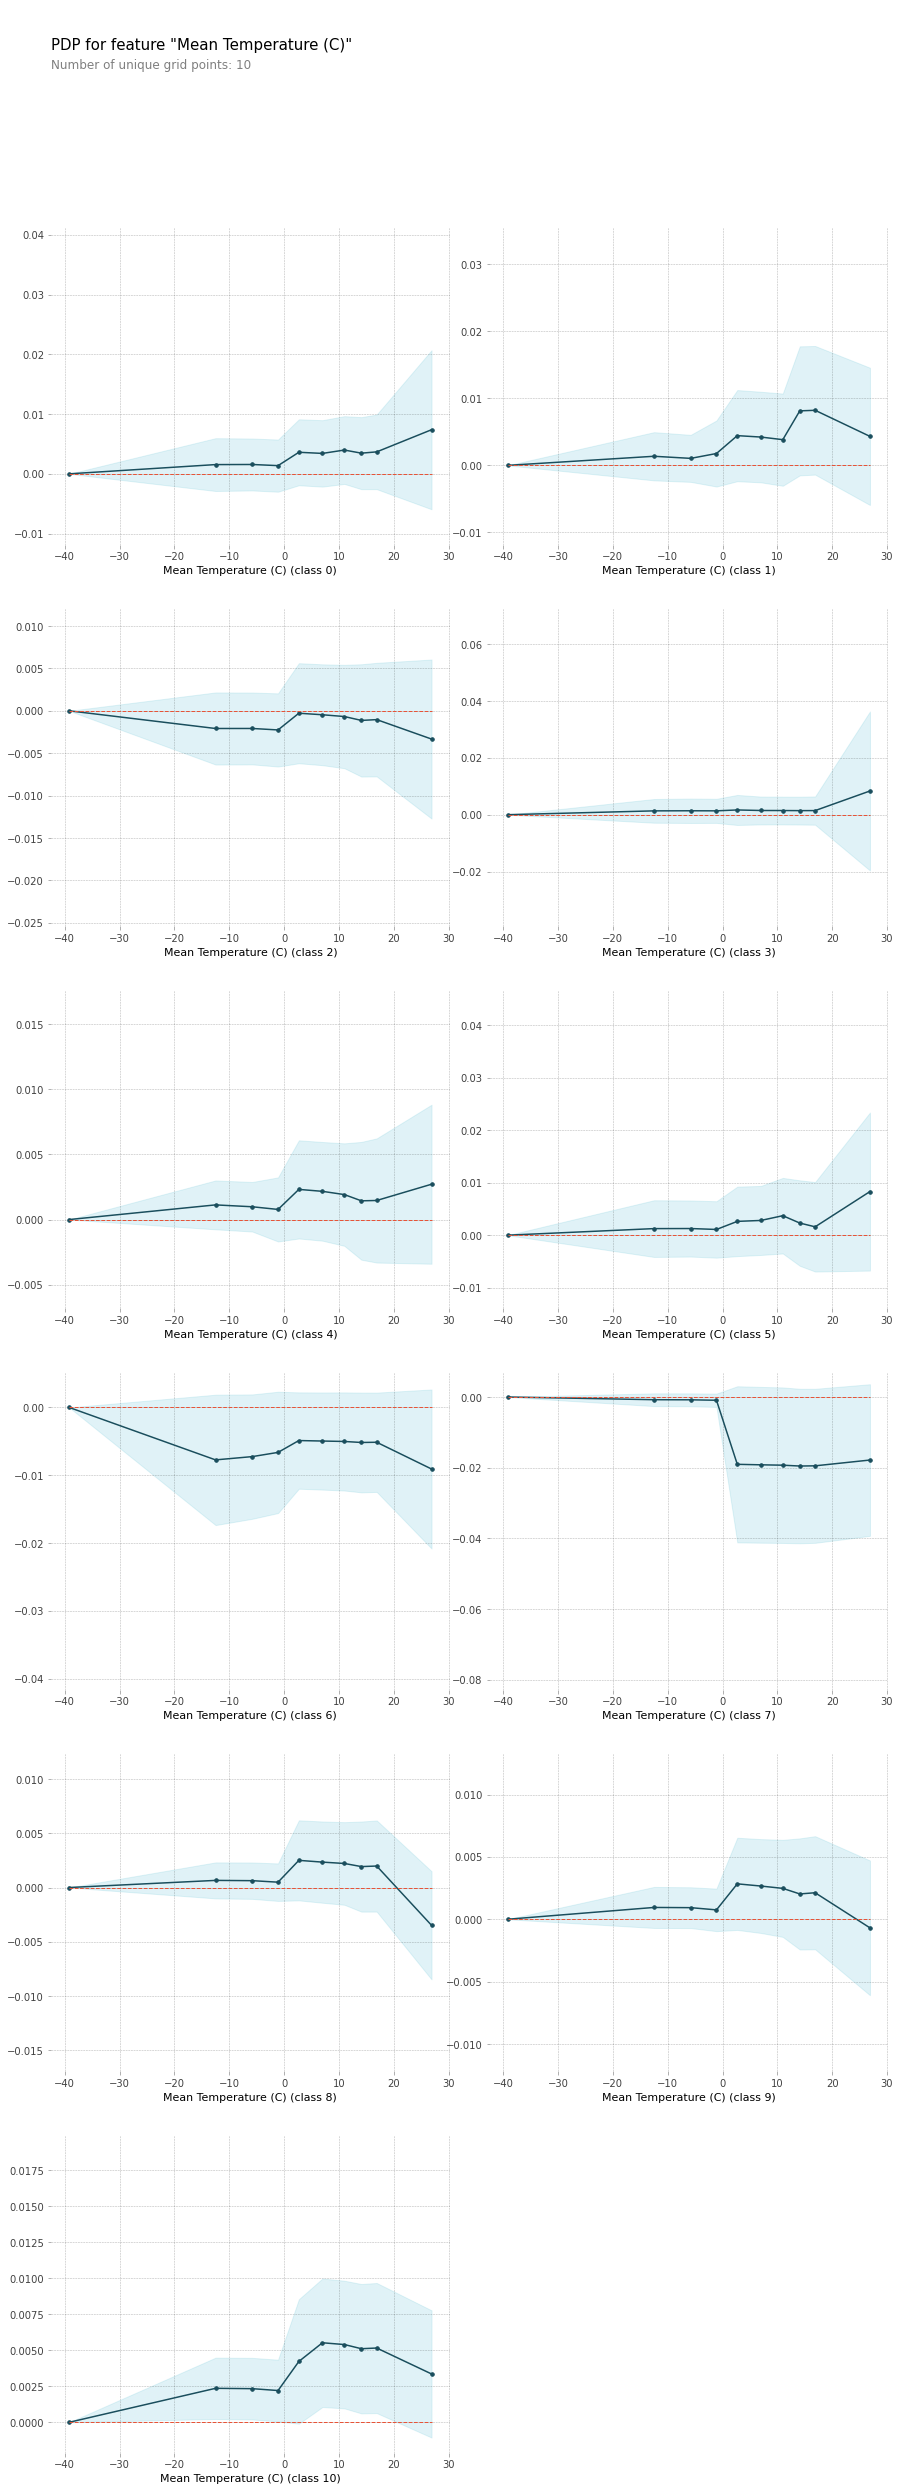

In [41]:

feature = 'Mean Temperature (C)'
isolate = pdp_isolate(
    model=model2,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolate, feature)

> ### Grid/Contour Plot

In [42]:
!pip install matplotlib==2.0.1

In [43]:
import matplotlib

In [44]:
from matplotlib.pyplot import clabel

In [45]:
matplotlib.__version__

'3.2.2'

TypeError: ignored

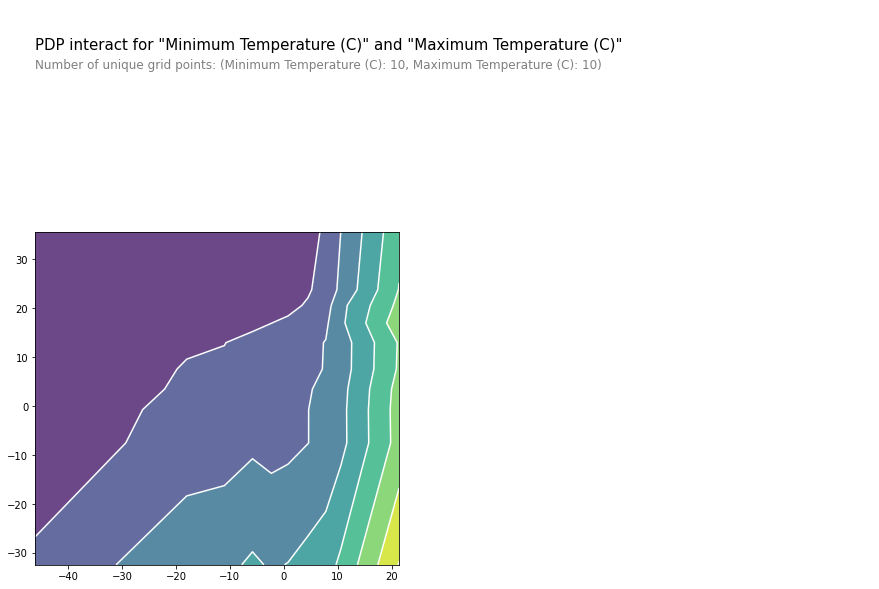

In [49]:
# NOTE: For some reason, there's a class error with this pdp.
  # When we visualize the graph, it throws an error that other
  # people online are having. It turns out that clabel is from an
  # outdated version of matplotlib; even though the plot visualizes 
  # fine, the error will still appear.
features = ['Minimum Temperature (C)', 'Maximum Temperature (C)']
interact = pdp_interact(
    model=model2,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

plot_params = {
    'title': 'Title',
    'subtitle': 'Subtitle',
    'title_fontsize': 16,
    'subtitle_fontsize': 14,
    # 'font_family': 'Gothic',
    'inter_fill_alpha': 0.8,
    'inter_fontsize': 12,
}
pdp_interact_plot(interact, feature_names=features, plot_type='contour')
ax.set_xlabel('xlabel', fontsize=18)
# ax.ylabel('ylabel', fontsize=16)
plt.savefig('pdp2.jpg')

---

#######################################################################################################

---

# **Build Model 3: Timeseries Forecast Model**

THIS IS THE MODEL I WILL USE TO ANSWER MY RESEARCH QUESTION.

https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/#:~:text=Prophet%2C%20or%20%E2%80%9CFacebook%20Prophet%2C,trends%2C%20seasonality%2C%20and%20holidays.


https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/


## Build Model 3

In [ ]:
# Because we are doing a timeseries forecast,
# we're going to use Prophet
from fbprophet import Prophet
prophet_df = december[['Date', 'Mean Temperature (C)']]

prophet_df.columns=['ds', 'y']
# december.columns = ['Date', target]

model3 = Prophet()

model3.fit(prophet_df)

In [ ]:
future = model3.make_future_dataframe(periods=366)
future.tail()

In [ ]:
future.head()

In [ ]:
forecast = model3.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig1 = model3.plot_components(forecast)

In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model3, forecast)

In [ ]:
plot_components_plotly(model3, forecast)

In [ ]:
###############

## Tune Model 3

## Check Metrics, Model 3

> ### MAE 

In [ ]:
print('Training MAE (PROPHET): ', mae(y_train, model1.predict(X_train)))
print('Validation MAE (PROPHET): ', mae(y_val, model1.predict(X_val)))